In [225]:
#Импорт библиотек
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [227]:
#Загрузка данных
data = yf.download('NVDA', start='2020-01-01', end='2024-01-01')
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']
data['Price_Change'] = data['Close'].diff()
data.fillna(data.bfill(),inplace=True)
data.fillna(data.ffill(), inplace=True)

[*********************100%***********************]  1 of 1 completed


In [228]:
data.head(30)

Price,Adj Close,Close,High,Low,Open,Volume,SMA_10,SMA_20,EMA_10,Volatility,Price_Change
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,
Date,,,,,,,,,,,
2020-01-02 00:00:00+00:00,5.973122,5.99775,5.99775,5.91800,5.96875,237536000,6.063800,6.130800,5.997750,0.07975,-0.09600
2020-01-03 00:00:00+00:00,5.877516,5.90175,5.94575,5.85250,5.87750,205384000,6.063800,6.130800,5.980295,0.09325,-0.09600
2020-01-06 00:00:00+00:00,5.902165,5.92650,5.93175,5.78175,5.80800,262636000,6.063800,6.130800,5.970514,0.15000,0.02475
2020-01-07 00:00:00+00:00,5.973620,5.99825,6.04425,5.90975,5.95500,314856000,6.063800,6.130800,5.975557,0.13450,0.07175
2020-01-08 00:00:00+00:00,5.984824,6.00950,6.05100,5.95375,5.99400,277108000,6.063800,6.130800,5.981729,0.09725,0.01125
2020-01-09 00:00:00+00:00,6.050553,6.07550,6.14825,6.02150,6.09625,255112000,6.063800,6.130800,5.998778,0.12675,0.06600
2020-01-10 00:00:00+00:00,6.082919,6.10800,6.21375,6.09375,6.18325,316296000,6.063800,6.130800,6.018636,0.12000,0.03250
2020-01-13 00:00:00+00:00,6.273633,6.29950,6.32475,6.16875,6.19150,319840000,6.063800,6.130800,6.069703,0.15600,0.19150


In [229]:
#Нормировка данных
features = ['Close', 'SMA_10', 'SMA_20', 'EMA_10', 'Volatility', 'Price_Change']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

In [230]:
#Параметр длины окна
seq_length = 60

In [231]:
#Создание временных окон
def create_multifeature_sequences(data, seq_length, stride):
    x, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)


x, y = create_multifeature_sequences(scaled_data, seq_length, stride=1)

In [232]:
#Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [233]:
#Преобразование в torch тензоры
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [234]:
#LSTM модель
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

input_size = len(features)
hidden_size = 1000
num_layers = 2
output_size = 1


In [235]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

In [236]:
#Определение функции потерь и отпимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [237]:
#Число эпох и размер батча
num_epochs = 20
batch_size = 64

In [238]:
#Обучение модели
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/20], Loss: 0.0006
Epoch [10/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0059
Epoch [20/20], Loss: 0.0007


In [239]:
#Тестирование модели
model.eval()
with torch.no_grad():
    y_pred = model(x_test).squeeze()
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

In [240]:
# Масштабирование обратно
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((y_pred.reshape(-1, 1), np.zeros((len(y_pred), len(features)-1))), axis=1)
)[:, 0]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))), axis=1)
)[:, 0]


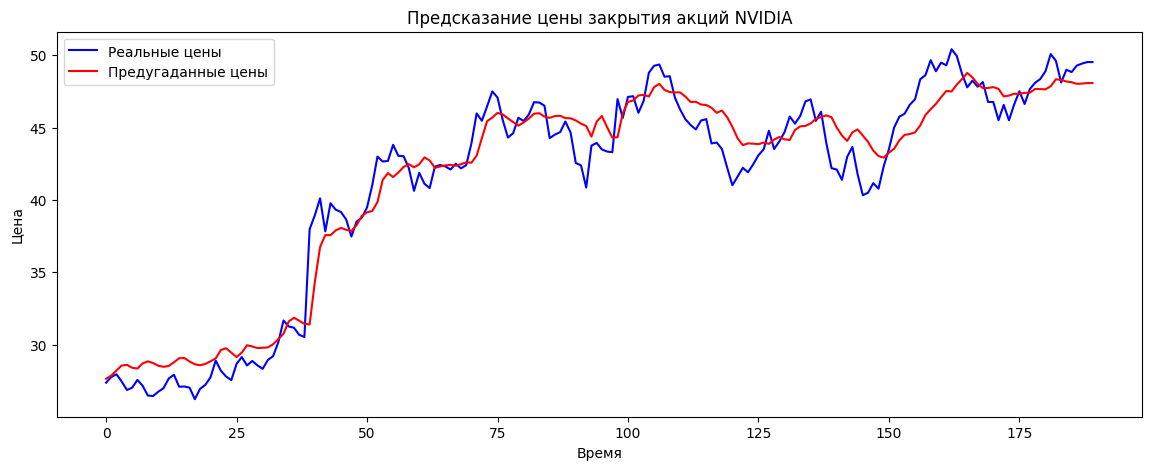

In [241]:
#Постройка графика
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Реальные цены', color='blue')
plt.plot(y_pred_rescaled, label='Предугаданные цены', color='red')
plt.title('Предсказание цены закрытия акций NVIDIA')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend()
plt.show()